In [18]:
import re  # Para trabajar con expresiones regulares
import spacy  # Para procesamiento de lenguaje natural (NLP)
import unicodedata  # Para normalizar caracteres Unicode
import spacy
import nltk
import stanza
from sklearn.feature_extraction.text import TfidfVectorizer
import plotly.graph_objects as go
from transformers import AutoTokenizer
from flair.data import Sentence
from flair.models import SequenceTagger
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
from tabulate import tabulate  # opcional si quieres una tabla más bonita
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
!python -m spacy download es_core_news_sm

     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     -------------------------- ------------- 8.7/12.9 MB 50.1 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 48.9 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [6]:
nlp = spacy.load("es_core_news_sm")  #cargar el modelo en español

In [7]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('spanish'))

In [9]:
file_path = "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/"


In [10]:
file_names = [
    "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discuros Gabriel García Marquez.txt",
    "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discurso Albert Camus.txt",
    "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discurso Bob Dylan.txt",
    "C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP\Clase_5/Discurso Vargas Llosa.txt"
]

In [11]:
data = []

for name in file_names:
    ruta_completa = os.path.join(file_path, name)
    
    try:
        # Primero intento con utf-8
        try:
            with open(ruta_completa, "r", encoding="utf-8") as f:
                contenido = f.read()
        except UnicodeDecodeError:
            # Si falla, reintento con latin1
            with open(ruta_completa, "r", encoding="latin1") as f:
                contenido = f.read()
        
        data.append((name, contenido))
    
    except FileNotFoundError:
        print(f"❌ No se encontró el archivo {ruta_completa}")
    except Exception as e:
        print(f"⚠️ Error con {ruta_completa}: {e}")

df = pd.DataFrame(data, columns=["nombre_archivo", "contenido"])
print(tabulate(df, headers='keys', tablefmt='fancy_grid', showindex=False))
stop_words = set(stopwords.words('spanish'))


╒═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════

In [12]:
def preprocess_text(text):
    # Normalizar caracteres Unicode (ej. á → a)
    text = unicodedata.normalize("NFKD", text)
    text = "".join([c for c in text if not unicodedata.combining(c)])

    # Procesar con spaCy
    doc = nlp(text.lower())

    # Extraer tokens, eliminar stopwords y puntuación
    tokens = [
        token.text for token in doc
        if token.text.strip() != ""               # elimina espacios y saltos de línea
        and token.text != "\n"                   # elimina tokens de salto explícito
        and token.text not in stop_words         # elimina stopwords
        and not token.is_punct                   # elimina puntuación
    ]

    return tokens

In [13]:
df["clear_text"] = df["contenido"].apply(preprocess_text)

In [14]:
df.head()

,nombre_archivo,contenido,clear_text
0,C:/Users/ACER/OneDrive/Documentos/Analitica de...,Discurso de aceptación del Premio Nobel\nLa so...,"[discurso, aceptacion, premio, nobel, soledad,..."
1,C:/Users/ACER/OneDrive/Documentos/Analitica de...,«Al recibir la distinción con que ha querido h...,"[recibir, distincion, querido, honrarme, libre..."
2,C:/Users/ACER/OneDrive/Documentos/Analitica de...,"Discurso en el banquete del Nobel, 10 de dicie...","[discurso, banquete, nobel, 10, diciembre, 201..."
3,C:/Users/ACER/OneDrive/Documentos/Analitica de...,Elogio de la lectura y la ficción\nAprendí a l...,"[elogio, lectura, ficcion, aprendi, leer, cinc..."


In [15]:
# 1. Convertir las listas de tokens en texto (string)
df['clear_text_str'] = df['clear_text'].apply(lambda x: " ".join(x))

# 2. Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# 3. Ajustar y transformar
tfidf_matrix = vectorizer.fit_transform(df['clear_text_str'])

# 4. Convertir a DataFrame para visualizar
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=df['nombre_archivo'],
    columns=vectorizer.get_feature_names_out()
)

# Mostrar las primeras filas
tfidf_df.head()

,000,10,100,12,120,16,17,1970,1979,1982,...,voz,vuelo,vuelve,vuelven,vulnerable,washington,william,xiaobo,xvi,york
nombre_archivo,,,,,,,,,,,,,,,,,,,,,
C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discuros Gabriel García Marquez.txt,0.000000,0.019237,0.024399,0.024399,0.024399,0.024399,0.024399,0.024399,0.024399,0.024399,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019237,0.000000,0.024399,0.019237
C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discurso Albert Camus.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.030556,0.000000,0.000000,0.000000,0.000000,0.000000
C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discurso Bob Dylan.txt,0.046781,0.036883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036883,0.000000,0.000000,0.000000
C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP\Clase_5/Discurso Vargas Llosa.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012428,0.012428,0.024856,0.024856,0.000000,0.012428,0.000000,0.012428,0.000000,0.009798


In [16]:
nltk.download("punkt")
nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r"[^a-záéíóúüñ\s]", "", texto)
    tokens = word_tokenize(texto, language="spanish")
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

df["tokens"] = df["contenido"].apply(limpiar_texto)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
 #Cargar modelo español con vectores Vectorización con spaCy (similar a GloVe)
nlp = spacy.load("es_core_news_md")

def vector_spacy(texto):
    doc = nlp(texto)
    return doc.vector  # embedding promedio del discurso

# Crear embeddings por discurso
df["vector_glove"] = df["contenido"].apply(vector_spacy)

# Pasar a DataFrame
glove_df = pd.DataFrame(df["vector_glove"].tolist(), index=df["nombre_archivo"])
print(glove_df.head())

                                                         0         1    \
nombre_archivo                                                           
C:/Users/ACER/OneDrive/Documentos/Analitica de ...  1.628125  1.294422   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...  1.454557  1.487067   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...  1.072020  0.745855   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...  1.563794  1.221171   

                                                         2         3    \
nombre_archivo                                                           
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.159822 -0.323337   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.537757 -0.584445   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.539653 -0.092211   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.253792 -0.562523   

                                                         4         5    \
nombre_archivo                      

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D

In [ ]:
###### 3. Vectorización con Keras Embedding (similar a Word2Vec)

# Tokenización y secuencias
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["contenido"])
sequences = tokenizer.texts_to_sequences(df["contenido"])
padded = pad_sequences(sequences, padding="post")

# Parámetros
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # dimensiones del vector

# Modelo simple con capa de embeddings
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padded.shape[1]),
    GlobalAveragePooling1D()
])

# Obtener embeddings
embeddings = model.predict(padded)

# Guardar en DataFrame
w2v_df = pd.DataFrame(embeddings, index=df["nombre_archivo"])
print(w2v_df.head())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
                                                          0         1   \
nombre_archivo                                                           
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.015183 -0.027913   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.017886 -0.032930   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.020794 -0.039224   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.004022 -0.001409   

                                                          2         3   \
nombre_archivo                                                           
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.004242 -0.006646   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.005962 -0.009677   
C:/Users/ACER/OneDrive/Documentos/Analitica de ... -0.007019 -0.011965   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...  0.001259  0.004265   

                                                          4         5  

### TECNICA DE n-grams

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
# Usamos los textos ya limpios (unidos en string)
df["texto_limpio"] = df["tokens"].apply(lambda x: " ".join(x))

# Ejemplo: Bigrams (n=2)
bigram_vectorizer = CountVectorizer(ngram_range=(2,2), max_features=20)  # top 20 bigramas
X_bigrams = bigram_vectorizer.fit_transform(df["texto_limpio"])

# DataFrame con frecuencias
bigrams_df = pd.DataFrame(X_bigrams.toarray(), 
                          columns=bigram_vectorizer.get_feature_names_out(), 
                          index=df["nombre_archivo"])

print(bigrams_df.head())

                                                    academia sueca  \
nombre_archivo                                                       
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               1   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               2   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               0   

                                                    américa latina  cada vez  \
nombre_archivo                                                                 
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               6         3   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               0         1   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               0         0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...               8         1   

                                                    hace años  \
nombre_archivo                   

In [29]:
# Trigramas (n=3)
trigram_vectorizer = CountVectorizer(ngram_range=(3,3), max_features=20)
X_trigrams = trigram_vectorizer.fit_transform(df["texto_limpio"])

trigrams_df = pd.DataFrame(X_trigrams.toarray(),
                           columns=trigram_vectorizer.get_feature_names_out(),
                           index=df["nombre_archivo"])

print(trigrams_df.head())

                                                    armas destrucción masiva  \
nombre_archivo                                                                 
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                         0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                         0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                         0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                         2   

                                                    ganar premio nobel  \
nombre_archivo                                                           
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                   0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                   0   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                   2   
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                   0   

                                                    mundo américa latina  

In [30]:
# Bigrams y trigrams en todo el corpus
vectorizer = CountVectorizer(ngram_range=(2,3))  # bigramas y trigramas
X = vectorizer.fit_transform(df["texto_limpio"])

# Sumar frecuencias
sumas = X.sum(axis=0)
frecuencias = [(ngram, sumas[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
frecuencias = sorted(frecuencias, key=lambda x: x[1], reverse=True)

# Top 20 n-grams
print(frecuencias[:20])


[('américa latina', np.int64(14)), ('primera vez', np.int64(7)), ('cada vez', np.int64(5)), ('premio nobel', np.int64(4)), ('pablo neruda', np.int64(3)), ('academia sueca', np.int64(3)), ('tal vez', np.int64(3)), ('thomas mann', np.int64(3)), ('hace años', np.int64(3)), ('puede ser', np.int64(3)), ('mundo entero', np.int64(3)), ('hombres mujeres', np.int64(3)), ('pasado vida', np.int64(3)), ('contó visto', np.int64(2)), ('cada día', np.int64(2)), ('hace tiempo', np.int64(2)), ('once años', np.int64(2)), ('tiempo mientras', np.int64(2)), ('guerra civil', np.int64(2)), ('pues si', np.int64(2))]


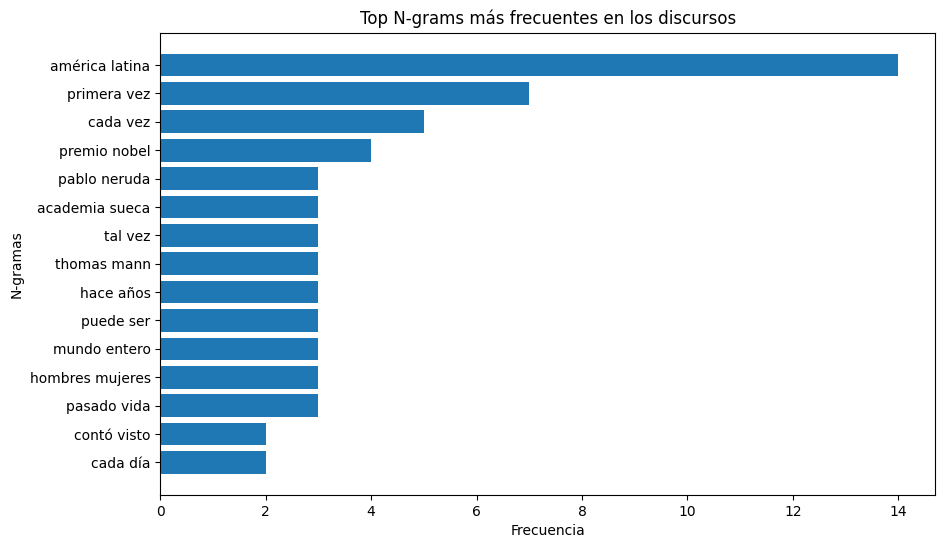

In [31]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Usamos los textos ya limpios
df["texto_limpio"] = df["tokens"].apply(lambda x: " ".join(x))

# Elegimos bigramas (2,2) o trigramas (3,3) según necesites
vectorizer = CountVectorizer(ngram_range=(2,2))  # aquí (2,2)=bigramas, cambia a (3,3) para trigramas
X = vectorizer.fit_transform(df["texto_limpio"])

# Sumar frecuencias
sumas = X.sum(axis=0)
frecuencias = [(ngram, sumas[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
frecuencias = sorted(frecuencias, key=lambda x: x[1], reverse=True)

# Tomamos el top 15
top_n = 15
ngrams, counts = zip(*frecuencias[:top_n])

# 📊 Gráfico
plt.figure(figsize=(10,6))
plt.barh(ngrams[::-1], counts[::-1])  # invertimos para que el más frecuente quede arriba
plt.title("Top N-grams más frecuentes en los discursos")
plt.xlabel("Frecuencia")
plt.ylabel("N-gramas")
plt.show()


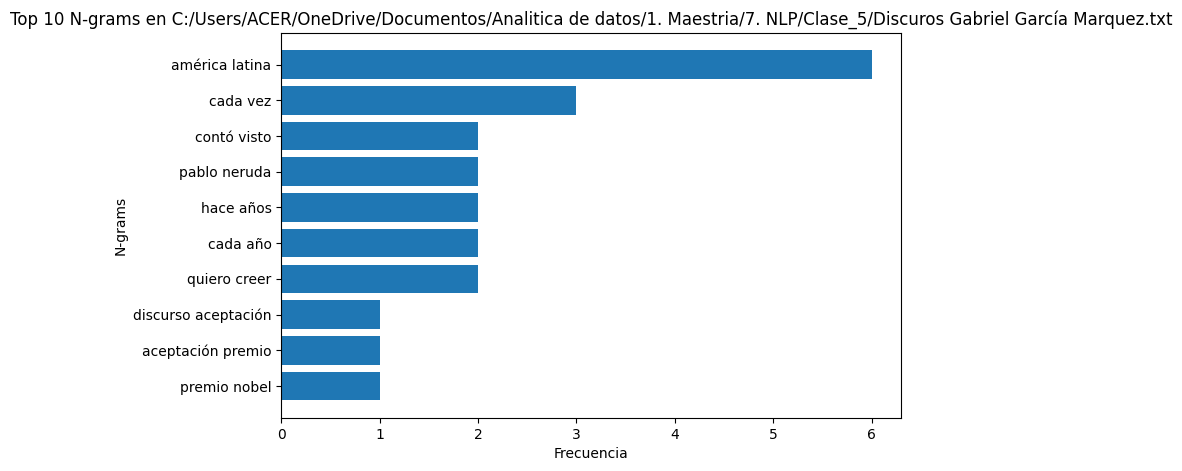

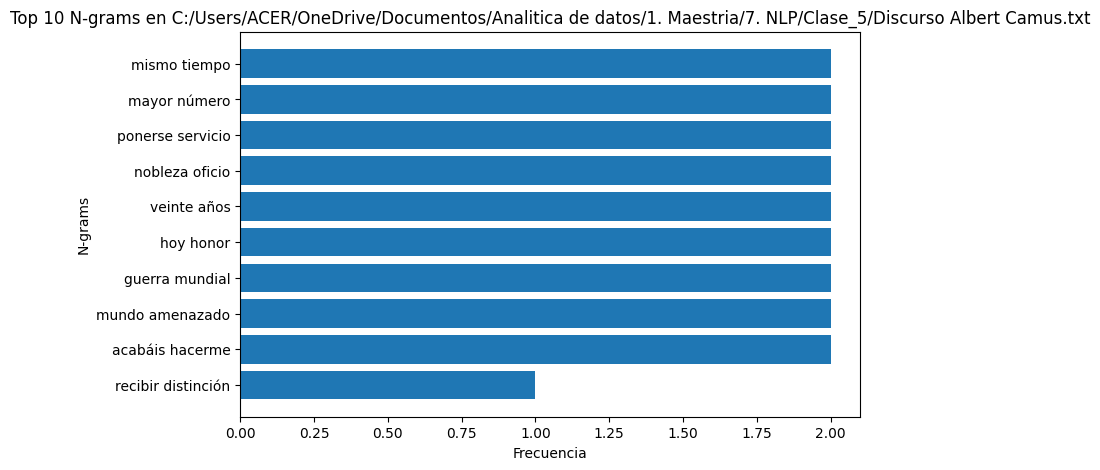

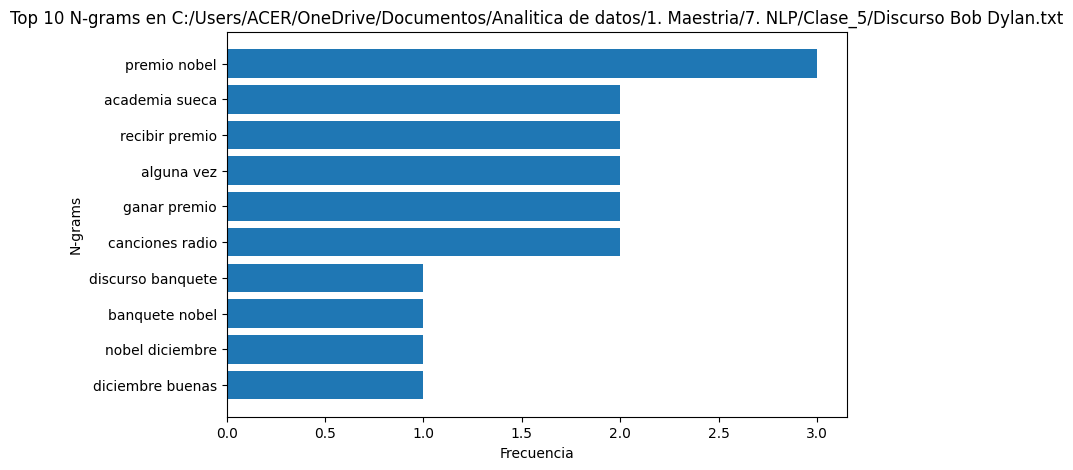

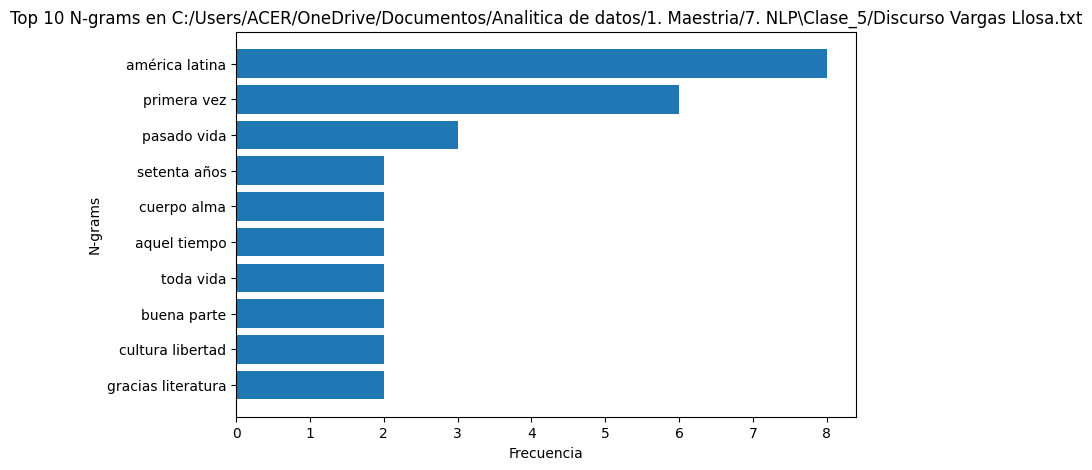

In [32]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

# Configuración general
top_n = 10   # número de n-grams a mostrar
ngram_tipo = (2,2)  # (2,2) = bigramas, (3,3) = trigramas

# Iterar sobre cada discurso
for idx, row in df.iterrows():
    nombre = row["nombre_archivo"]
    texto = " ".join(row["tokens"])  # texto limpio
    
    # Vectorizar
    vectorizer = CountVectorizer(ngram_range=ngram_tipo)
    X = vectorizer.fit_transform([texto])  # solo ese discurso
    
    # Frecuencias
    sumas = X.sum(axis=0)
    frecuencias = [(ngram, sumas[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    frecuencias = sorted(frecuencias, key=lambda x: x[1], reverse=True)[:top_n]
    
    if frecuencias:
        ngrams, counts = zip(*frecuencias)
        
        # 📊 Gráfico
        plt.figure(figsize=(8,5))
        plt.barh(ngrams[::-1], counts[::-1])
        plt.title(f"Top {top_n} N-grams en {nombre}")
        plt.xlabel("Frecuencia")
        plt.ylabel("N-grams")
        plt.show()



📖 Discuros Gabriel García Marquez.txt — Bigramas


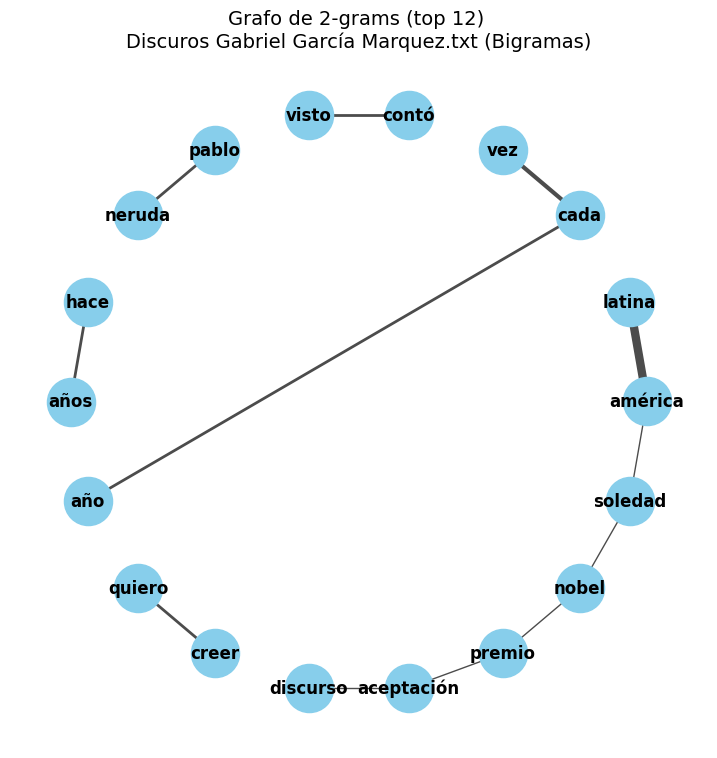


📖 Discuros Gabriel García Marquez.txt — Trigramas


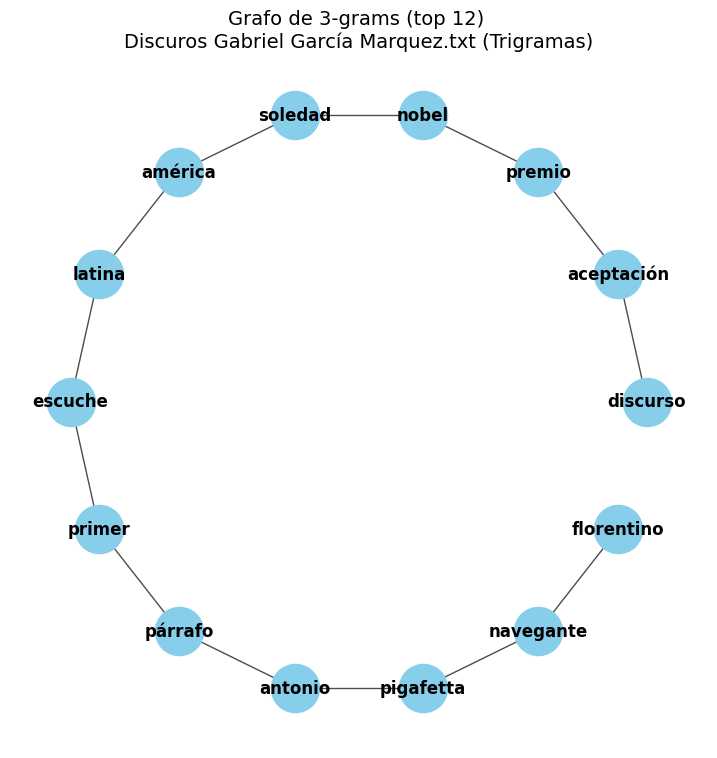


📖 Discurso Albert Camus.txt — Bigramas


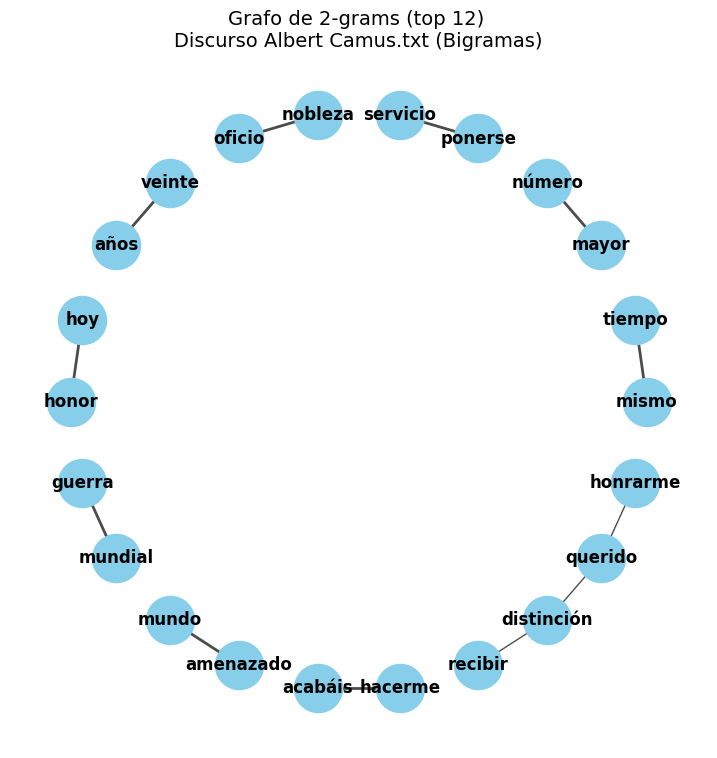


📖 Discurso Albert Camus.txt — Trigramas


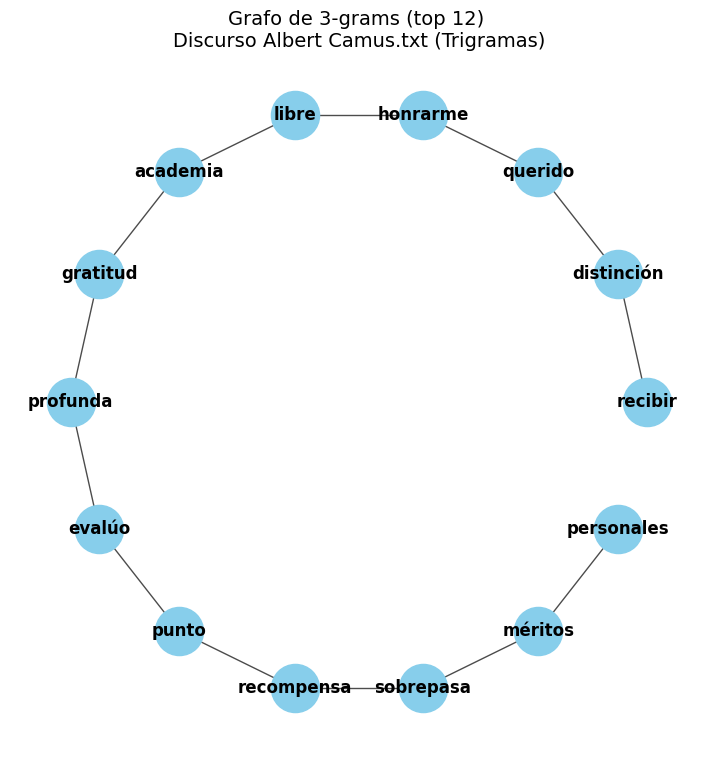


📖 Discurso Bob Dylan.txt — Bigramas


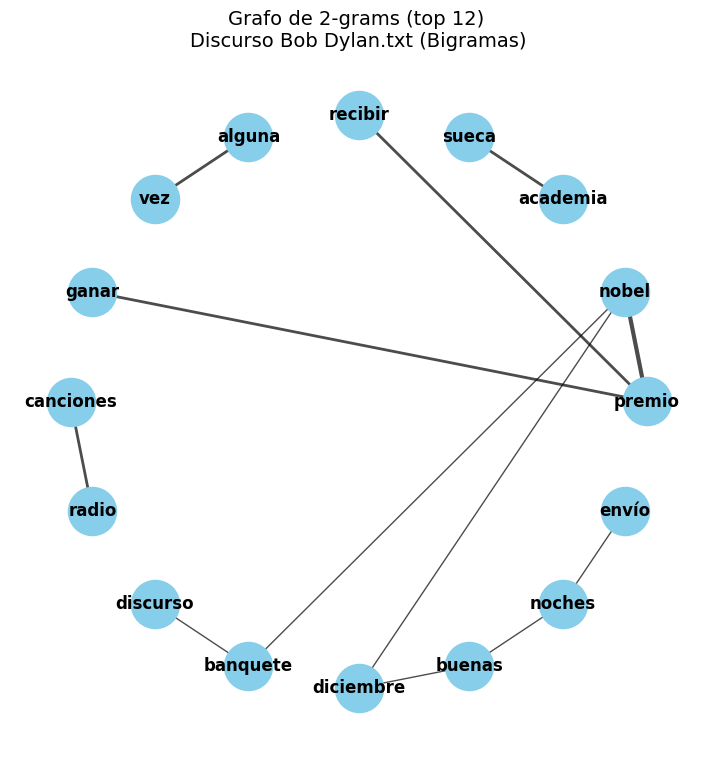


📖 Discurso Bob Dylan.txt — Trigramas


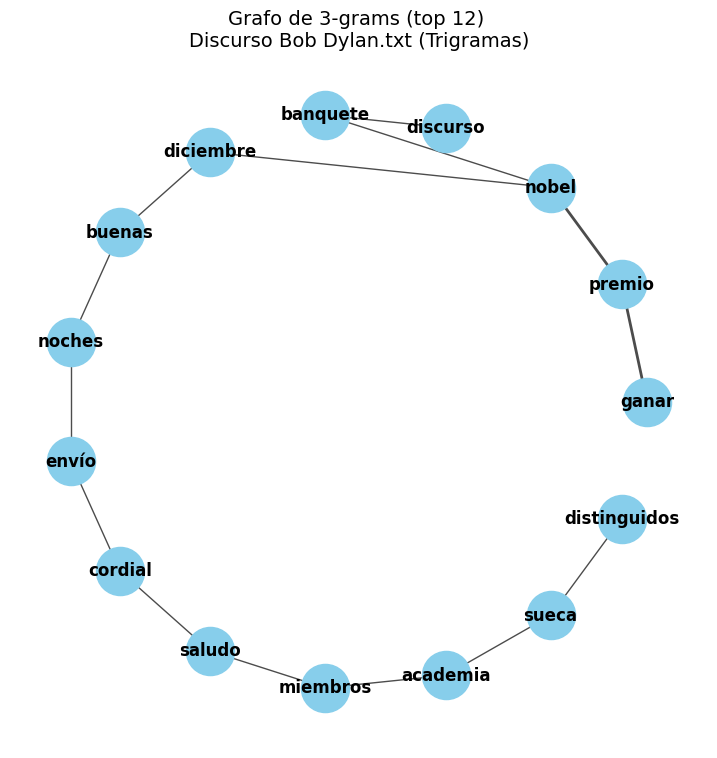


📖 Discurso Vargas Llosa.txt — Bigramas


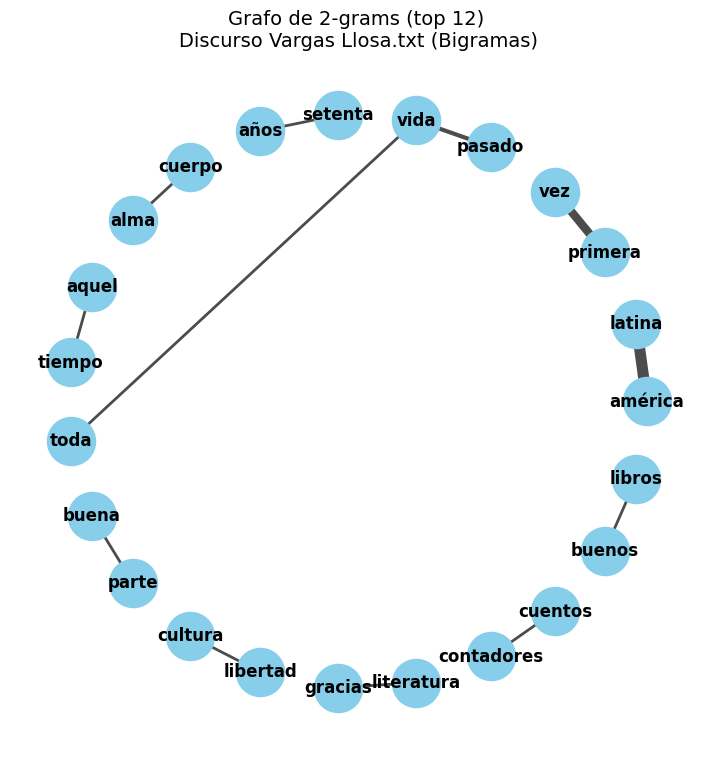


📖 Discurso Vargas Llosa.txt — Trigramas


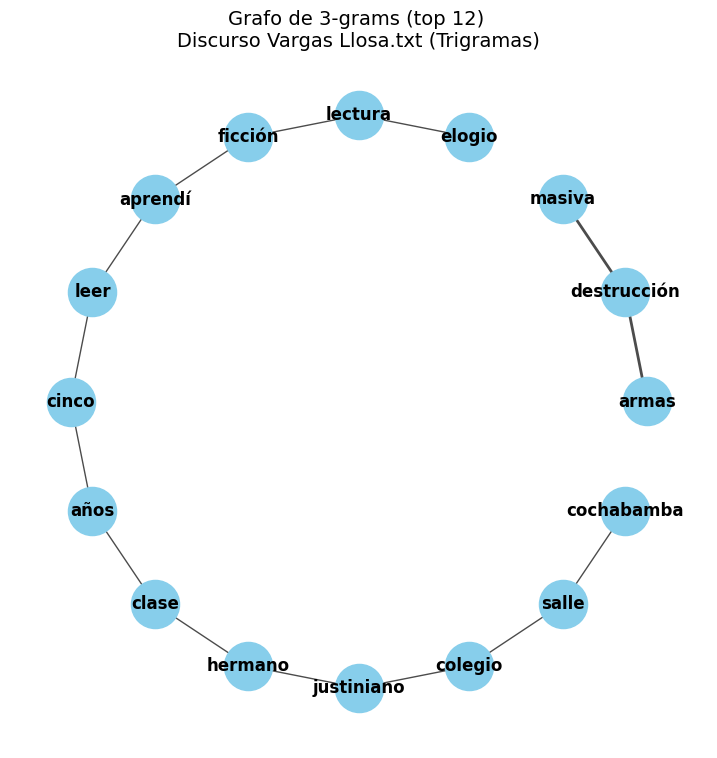

In [49]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os

def grafo_ngrams(texto, n=2, top_n=15, titulo_extra=""):
    # Vectorizar n-grams
    vectorizer = CountVectorizer(ngram_range=(n,n))
    X = vectorizer.fit_transform([texto])
    sumas = X.sum(axis=0)

    # Extraer n-grams más frecuentes
    ngrams = [(ngram, sumas[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)[:top_n]

    # Construir grafo
    G = nx.Graph()
    for ngram, freq in ngrams:
        palabras = ngram.split()
        if len(palabras) == 2:   # bigramas
            G.add_edge(palabras[0], palabras[1], weight=freq)
        elif len(palabras) == 3: # trigramas
            G.add_edge(palabras[0], palabras[1], weight=freq)
            G.add_edge(palabras[1], palabras[2], weight=freq)

    # Layout circular para evitar que se pisen
    pos = nx.circular_layout(G)

    # Dibujar
    plt.figure(figsize=(9,9))
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    plt.title(f"Grafo de {n}-grams (top {top_n}) {titulo_extra}", fontsize=14)
    plt.axis("off")
    plt.show()

# 🔄 Generar 2 grafos (bigramas y trigramas) por cada discurso
for idx, row in df.iterrows():
    texto = " ".join(row["tokens"])
    nombre_simple = os.path.basename(row["nombre_archivo"])  # quitar ruta
    
    print(f"\n📖 {nombre_simple} — Bigramas")
    grafo_ngrams(texto, n=2, top_n=12, titulo_extra=f"\n{nombre_simple} (Bigramas)")
    
    print(f"\n📖 {nombre_simple} — Trigramas")
    grafo_ngrams(texto, n=3, top_n=12, titulo_extra=f"\n{nombre_simple} (Trigramas)")




📖 Discuros Gabriel García Marquez.txt — Bigramas


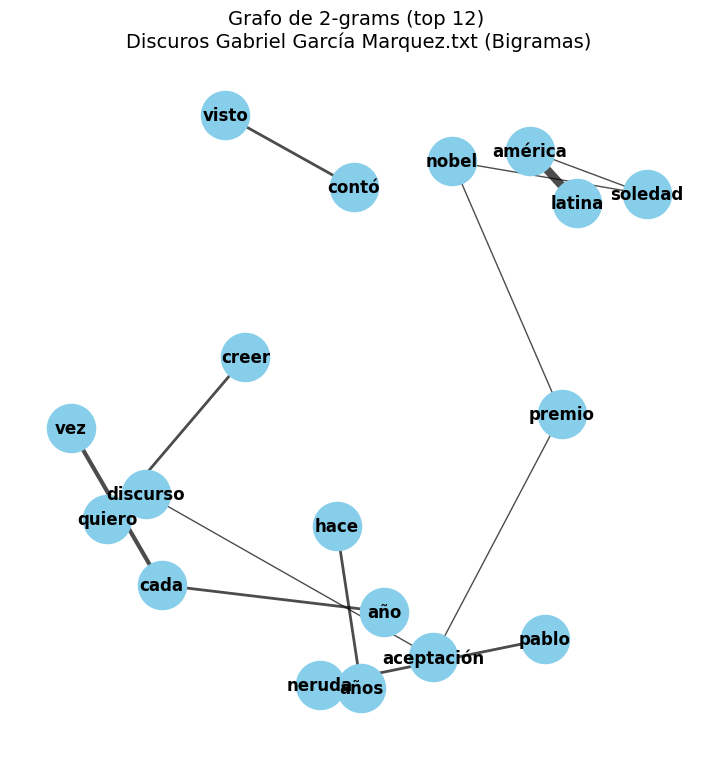


📖 Discuros Gabriel García Marquez.txt — Trigramas


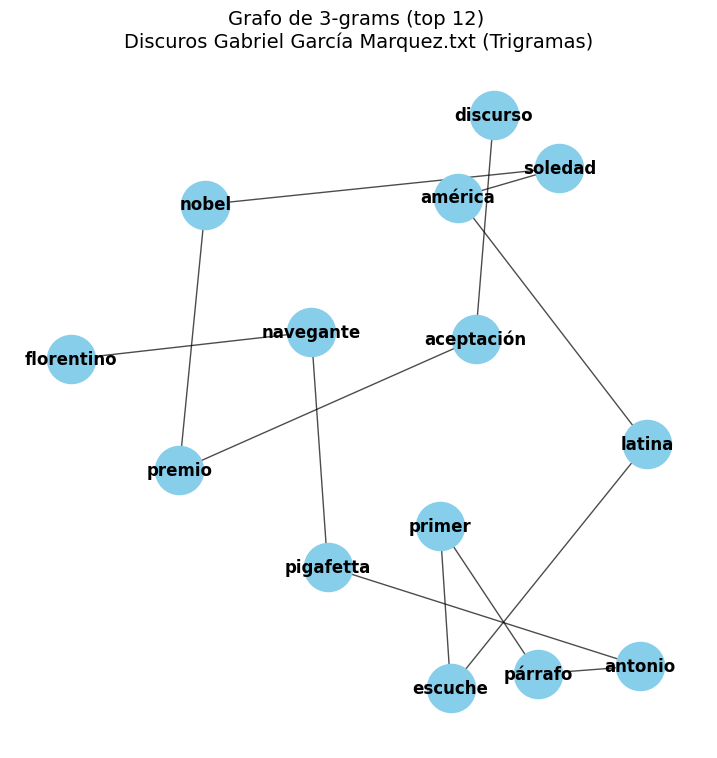


📖 Discurso Albert Camus.txt — Bigramas


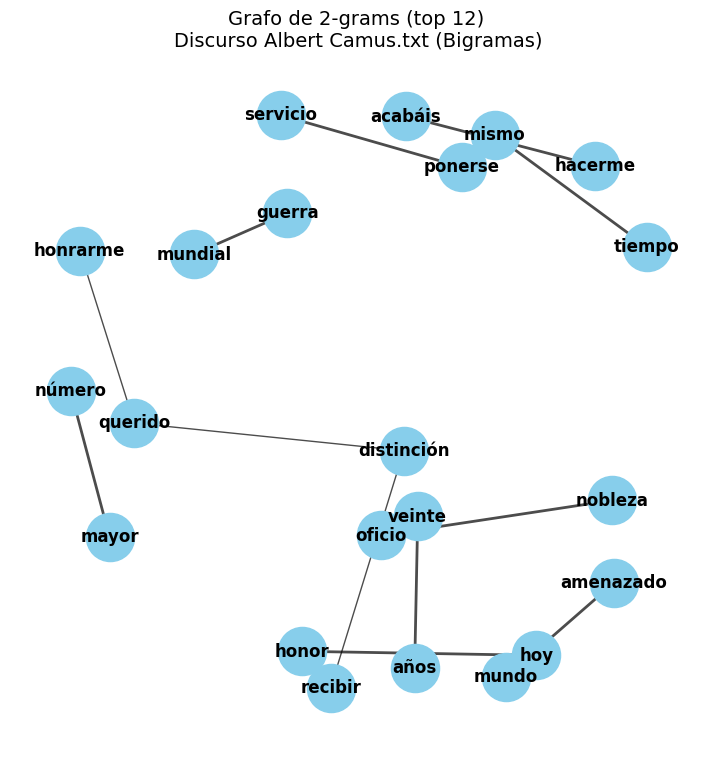


📖 Discurso Albert Camus.txt — Trigramas


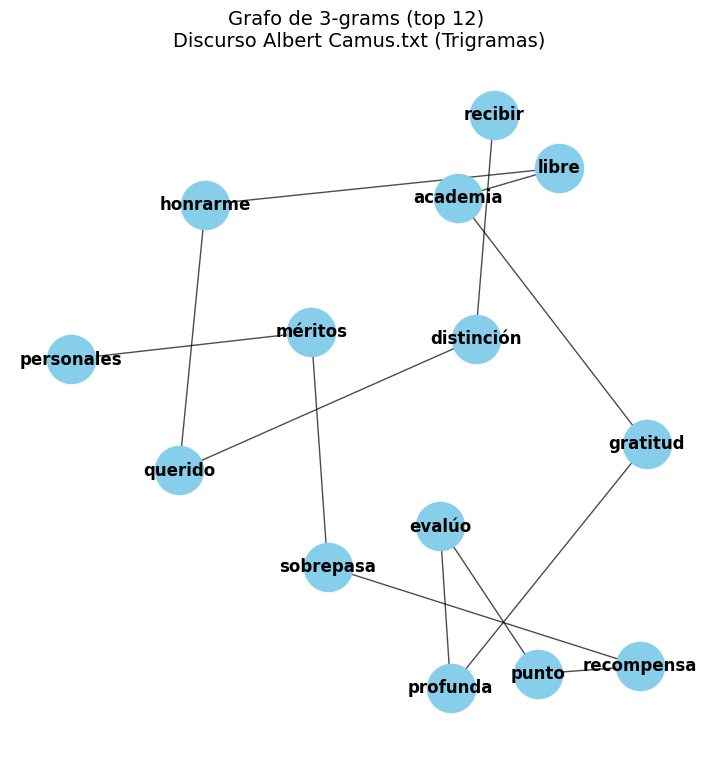


📖 Discurso Bob Dylan.txt — Bigramas


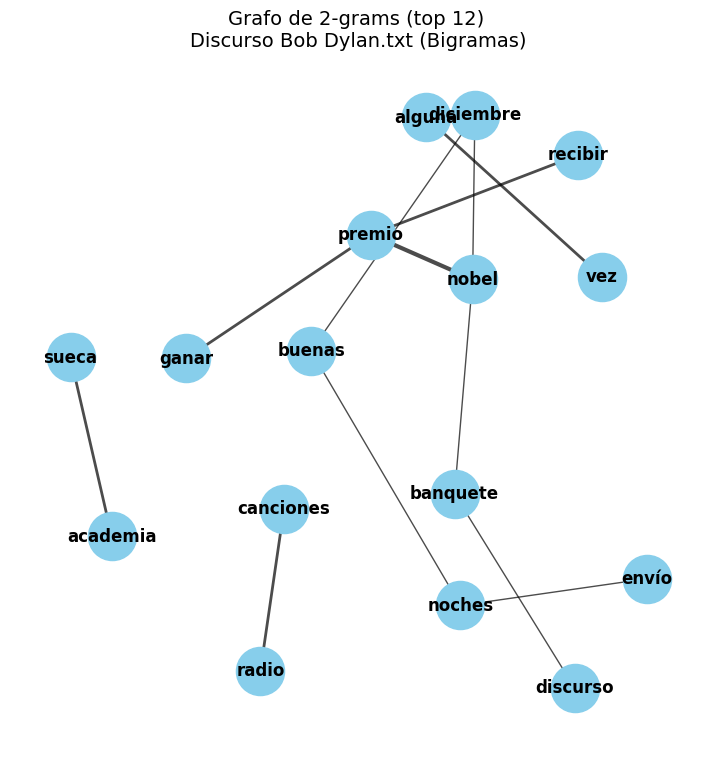


📖 Discurso Bob Dylan.txt — Trigramas


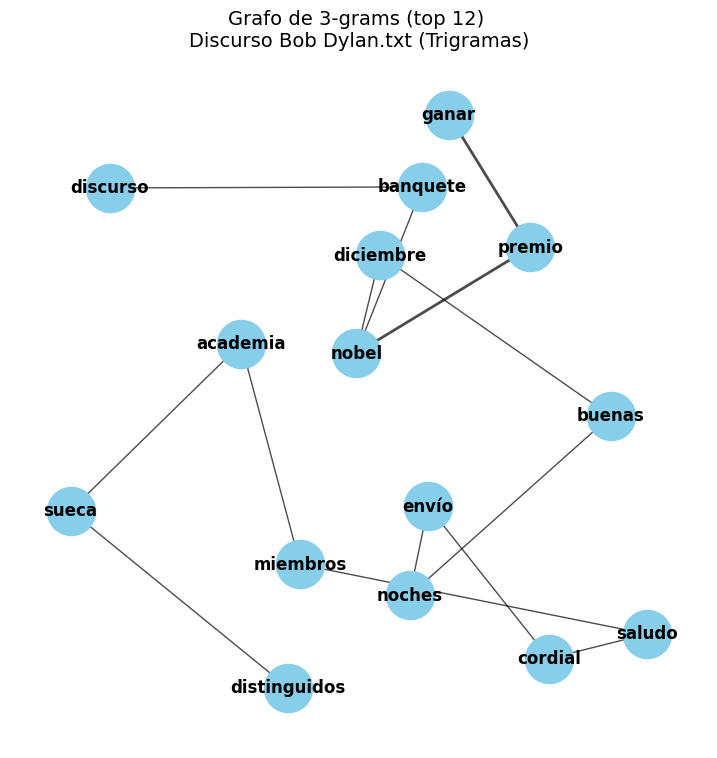


📖 Discurso Vargas Llosa.txt — Bigramas


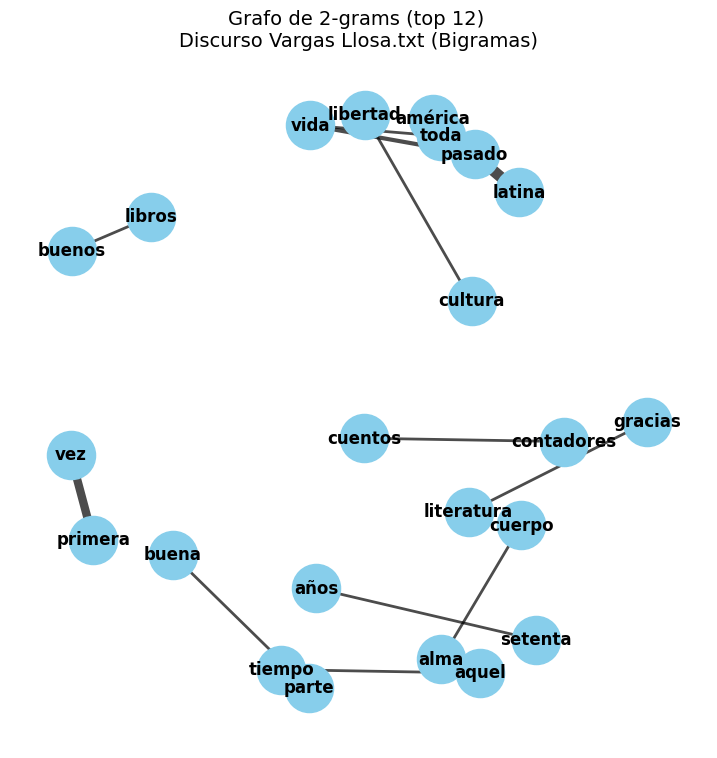


📖 Discurso Vargas Llosa.txt — Trigramas


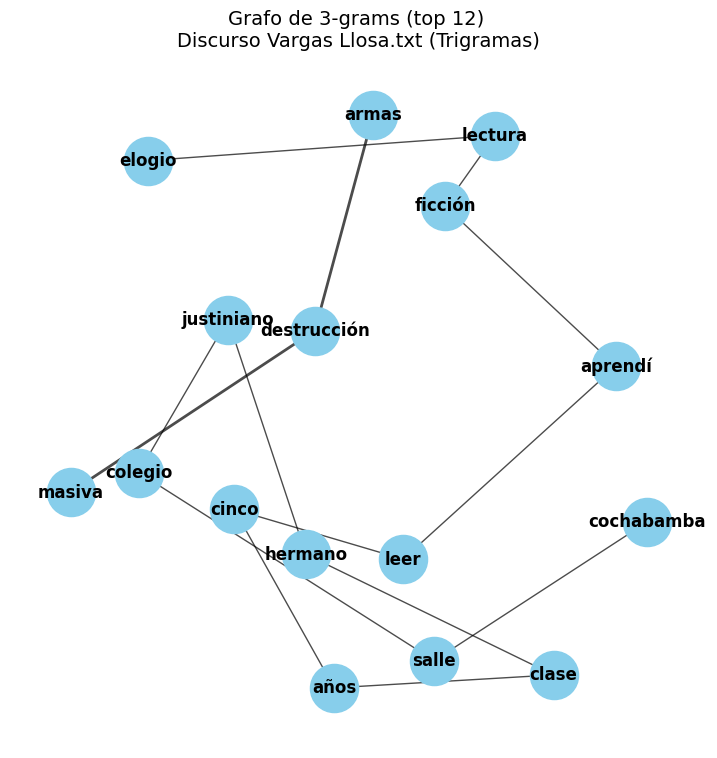

In [50]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import os

def grafo_ngrams(texto, n=2, top_n=15, titulo_extra=""):
    # Vectorizar n-grams
    vectorizer = CountVectorizer(ngram_range=(n,n))
    X = vectorizer.fit_transform([texto])
    sumas = X.sum(axis=0)

    # Extraer n-grams más frecuentes
    ngrams = [(ngram, sumas[0, idx]) for ngram, idx in vectorizer.vocabulary_.items()]
    ngrams = sorted(ngrams, key=lambda x: x[1], reverse=True)[:top_n]

    # Construir grafo
    G = nx.Graph()
    for ngram, freq in ngrams:
        palabras = ngram.split()
        if len(palabras) == 2:   # bigramas
            G.add_edge(palabras[0], palabras[1], weight=freq)
        elif len(palabras) == 3: # trigramas
            G.add_edge(palabras[0], palabras[1], weight=freq)
            G.add_edge(palabras[1], palabras[2], weight=freq)

    # Layout Spring (más orgánico y separado)
    pos = nx.spring_layout(G, k=1.2, seed=42)  

    # Dibujar
    plt.figure(figsize=(9,9))
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()], alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")
    plt.title(f"Grafo de {n}-grams (top {top_n}) {titulo_extra}", fontsize=14)
    plt.axis("off")
    plt.show()

# 🔄 Generar 2 grafos (bigramas y trigramas) por cada discurso
for idx, row in df.iterrows():
    texto = " ".join(row["tokens"])
    nombre_simple = os.path.basename(row["nombre_archivo"])  # solo el nombre del archivo
    
    print(f"\n📖 {nombre_simple} — Bigramas")
    grafo_ngrams(texto, n=2, top_n=12, titulo_extra=f"\n{nombre_simple} (Bigramas)")
    
    print(f"\n📖 {nombre_simple} — Trigramas")
    grafo_ngrams(texto, n=3, top_n=12, titulo_extra=f"\n{nombre_simple} (Trigramas)")


### Distancia del Coseno

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
### Distancia del Coseno
# --- IGNORE ---        

In [34]:
# Matriz de similitud coseno
cosine_tfidf = cosine_similarity(tfidf_df)

# DataFrame para interpretación
cosine_tfidf_df = pd.DataFrame(cosine_tfidf, 
                               index=df["nombre_archivo"], 
                               columns=df["nombre_archivo"])

print("🔹 Similitud coseno - TF-IDF")
print(cosine_tfidf_df.round(3))


🔹 Similitud coseno - TF-IDF
nombre_archivo                                      C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discuros Gabriel García Marquez.txt  \
nombre_archivo                                                                                                                                                            
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              1.000                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.233                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.190                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.311                

In [35]:
cosine_w2v = cosine_similarity(w2v_df)

cosine_w2v_df = pd.DataFrame(cosine_w2v, 
                             index=df["nombre_archivo"], 
                             columns=df["nombre_archivo"])

print("🔹 Similitud coseno - Word2Vec (Keras)")
print(cosine_w2v_df.round(3))


🔹 Similitud coseno - Word2Vec (Keras)
nombre_archivo                                      C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discuros Gabriel García Marquez.txt  \
nombre_archivo                                                                                                                                                            
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              1.000                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.999                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.998                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.054      

In [36]:
cosine_glove = cosine_similarity(glove_df)

cosine_glove_df = pd.DataFrame(cosine_glove, 
                               index=df["nombre_archivo"], 
                               columns=df["nombre_archivo"])

print("🔹 Similitud coseno - GloVe (spaCy)")
print(cosine_glove_df.round(3))


🔹 Similitud coseno - GloVe (spaCy)
nombre_archivo                                      C:/Users/ACER/OneDrive/Documentos/Analitica de datos/1. Maestria/7. NLP/Clase_5/Discuros Gabriel García Marquez.txt  \
nombre_archivo                                                                                                                                                            
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              1.000                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.966                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.914                                                                     
C:/Users/ACER/OneDrive/Documentos/Analitica de ...                                              0.981         

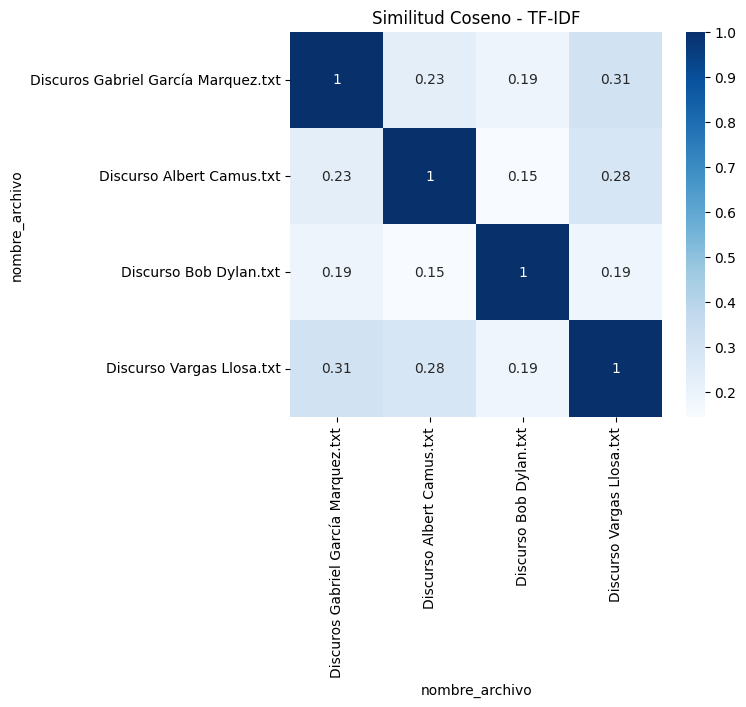

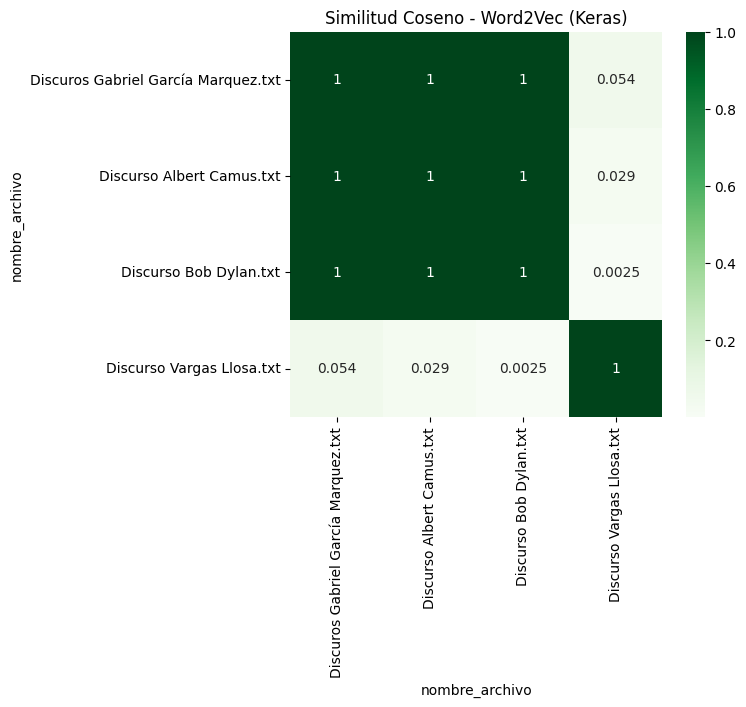

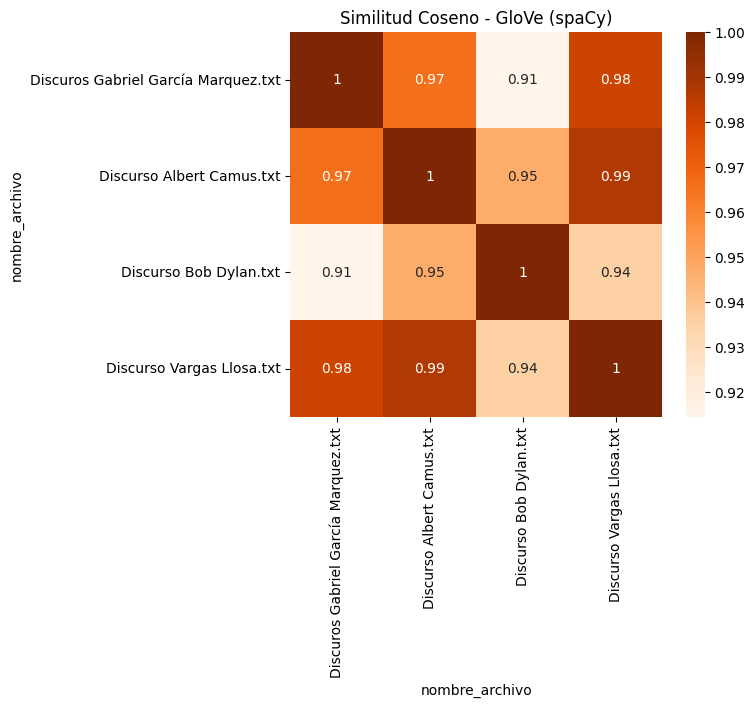

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Extraer solo el nombre del archivo (sin la ruta)
df["nombre_simple"] = df["nombre_archivo"].apply(lambda x: os.path.basename(x))

# --- TF-IDF ---
plt.figure(figsize=(6,5))
sns.heatmap(cosine_tfidf_df, annot=True, cmap="Blues", xticklabels=df["nombre_simple"], yticklabels=df["nombre_simple"])
plt.title("Similitud Coseno - TF-IDF")
plt.show()

# --- Word2Vec (Keras) ---
plt.figure(figsize=(6,5))
sns.heatmap(cosine_w2v_df, annot=True, cmap="Greens", xticklabels=df["nombre_simple"], yticklabels=df["nombre_simple"])
plt.title("Similitud Coseno - Word2Vec (Keras)")
plt.show()

# --- GloVe (spaCy) ---
plt.figure(figsize=(6,5))
sns.heatmap(cosine_glove_df, annot=True, cmap="Oranges", xticklabels=df["nombre_simple"], yticklabels=df["nombre_simple"])
plt.title("Similitud Coseno - GloVe (spaCy)")
plt.show()



Top palabras por tópico:

Tópico 0:
  vivir (9.33)
  arte (8.33)
  canciones (7.33)
  puede (6.33)
  nobel (6.33)
  mismo (6.33)
  escritor (6.33)
  verdad (6.33)
  sólo (6.33)
  historia (6.33)

Tópico 1:
  mil (9.34)
  américa (9.33)
  realidad (7.33)
  poesía (7.33)
  hoy (6.33)
  latina (6.33)
  veces (5.33)
  europa (5.33)
  sido (5.33)
  primer (4.33)

Tópico 2:
  literatura (22.34)
  vivir (15.33)
  perú (15.33)
  historia (14.33)
  escribir (12.33)
  historias (12.33)
  hace (11.33)
  españa (11.33)
  libertad (11.33)
  nunca (10.33)


Tópico dominante por documento:
                             documento  topico_dominante  prob_topico
0  Discuros Gabriel García Marquez.txt                 1     0.999361
1            Discurso Albert Camus.txt                 0     0.999010
2               Discurso Bob Dylan.txt                 0     0.997996
3            Discurso Vargas Llosa.txt                 2     0.999758


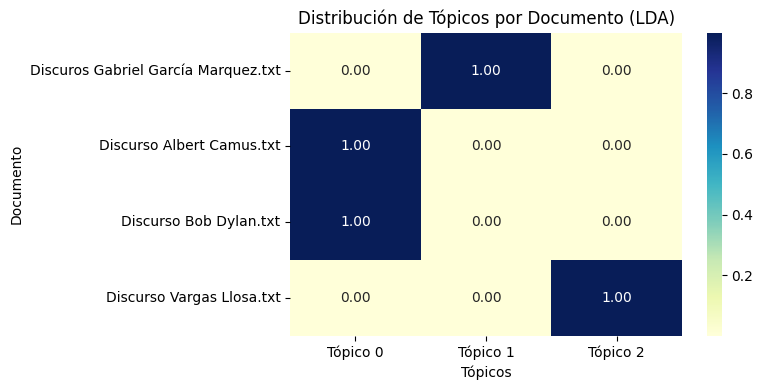

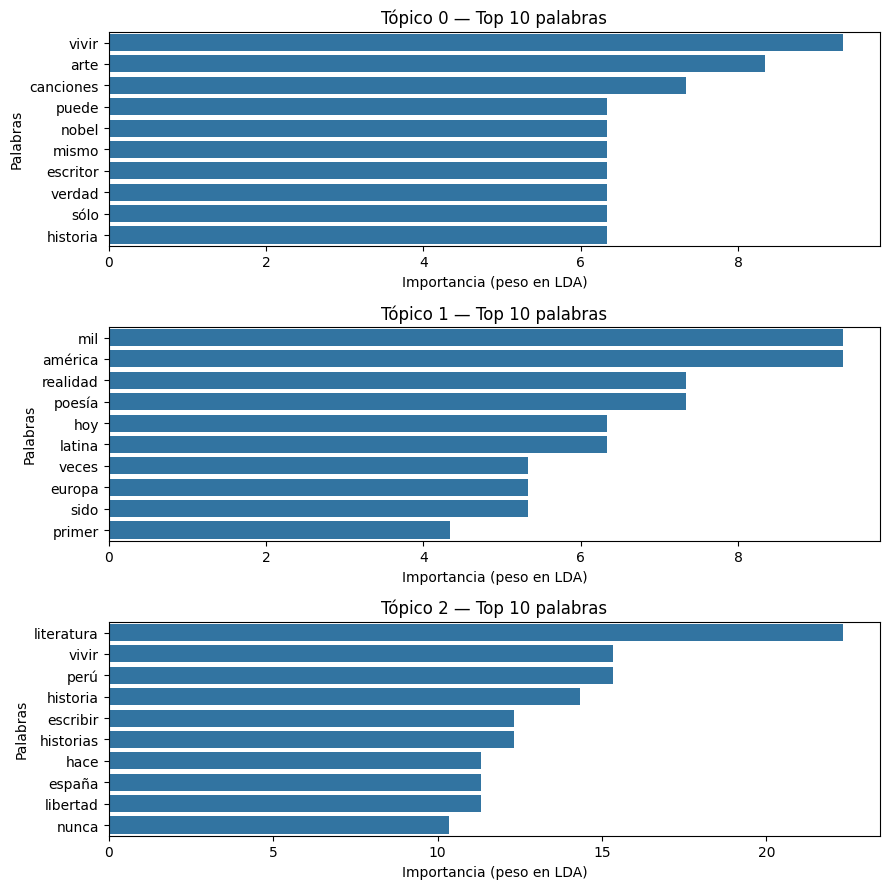

In [40]:
# Si no tienes sklearn instalado:
# !pip install scikit-learn seaborn matplotlib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ----- Parámetros -----
num_topics = 3       # número de tópicos (ajusta si quieres más/menos)
top_n_words = 10     # cuántas palabras mostrar por tópico

# ----- Preparar texto (unir tokens) -----
# Asegúrate de tener df["tokens"] como listas de tokens limpios.
df["texto_limpio"] = df["tokens"].apply(lambda x: " ".join(x))

# ----- Vectorizar (Bag-of-Words) -----
vectorizer = CountVectorizer(max_df=0.85, min_df=1)  # ajusta min_df si quieres filtrar raras
dtm = vectorizer.fit_transform(df["texto_limpio"])   # document-term matrix

# ----- Entrenar LDA (sklearn) -----
lda = LatentDirichletAllocation(n_components=num_topics,
                                random_state=42,
                                learning_method="batch",
                                max_iter=50)
doc_topic_dist = lda.fit_transform(dtm)  # shape: (n_docs, n_topics)

# ----- Top palabras por tópico -----
feature_names = vectorizer.get_feature_names_out()

print("\nTop palabras por tópico:\n")
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[::-1][:top_n_words]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = topic[top_indices]
    print(f"Tópico {topic_idx}:")
    for w, wt in zip(top_words, top_weights):
        print(f"  {w} ({wt:.2f})")
    print()

# ----- Asignación más probable por documento -----
doc_topic_df = pd.DataFrame(doc_topic_dist,
                            index=df["nombre_archivo"].apply(lambda x: os.path.basename(x)),
                            columns=[f"Tópico {i}" for i in range(num_topics)])

# Mostrar el tópico dominante por documento
df_result = pd.DataFrame({
    "documento": doc_topic_df.index,
    "topico_dominante": doc_topic_df.values.argmax(axis=1),
    "prob_topico": doc_topic_df.values.max(axis=1)
})
print("\nTópico dominante por documento:")
print(df_result)

# ----- Heatmap: distribución tópicos x documento -----
plt.figure(figsize=(8, 4))
sns.heatmap(doc_topic_df, annot=True, cmap="YlGnBu", fmt=".2f",
            xticklabels=doc_topic_df.columns, yticklabels=doc_topic_df.index)
plt.title("Distribución de Tópicos por Documento (LDA)")
plt.xlabel("Tópicos")
plt.ylabel("Documento")
plt.tight_layout()
plt.show()

# ----- Barras: top palabras por tópico (visual) -----
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(9, 3 * num_topics))
if num_topics == 1:
    axes = [axes]

for topic_idx, ax in enumerate(axes):
    topic = lda.components_[topic_idx]
    top_indices = topic.argsort()[::-1][:top_n_words]
    words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]
    sns.barplot(x=weights, y=words, ax=ax)
    ax.set_title(f"Tópico {topic_idx} — Top {top_n_words} palabras")
    ax.set_xlabel("Importancia (peso en LDA)")
    ax.set_ylabel("Palabras")

plt.tight_layout()
plt.show()


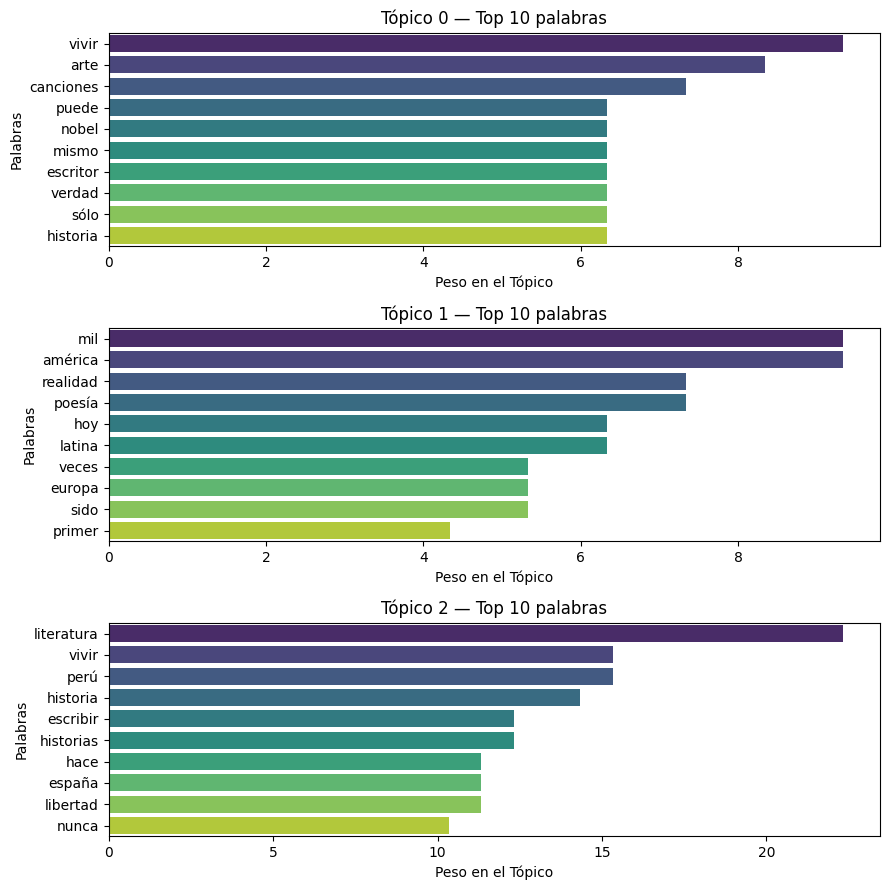

In [41]:
# Número de palabras a mostrar por tópico
top_n_words = 10  

# Sacar las palabras del vocabulario
feature_names = vectorizer.get_feature_names_out()

# Crear gráficos de barras para cada tópico
fig, axes = plt.subplots(nrows=num_topics, ncols=1, figsize=(9, 3 * num_topics))
if num_topics == 1:
    axes = [axes]

for topic_idx, ax in enumerate(axes):
    # Ordenar las palabras por importancia dentro del tópico
    topic = lda.components_[topic_idx]
    top_indices = topic.argsort()[::-1][:top_n_words]
    words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]

    # Graficar
    sns.barplot(x=weights, y=words, ax=ax, palette="viridis")
    ax.set_title(f"Tópico {topic_idx} — Top {top_n_words} palabras")
    ax.set_xlabel("Peso en el Tópico")
    ax.set_ylabel("Palabras")

plt.tight_layout()
plt.show()


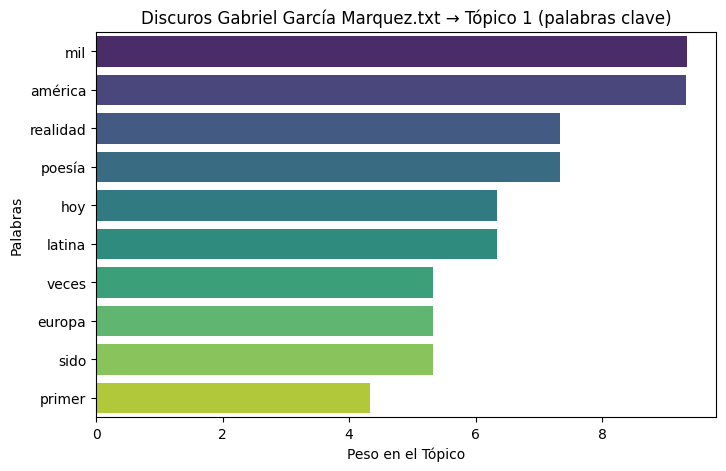

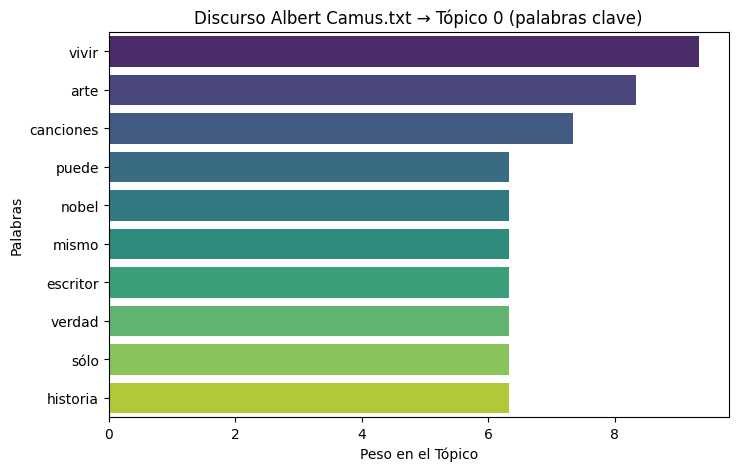

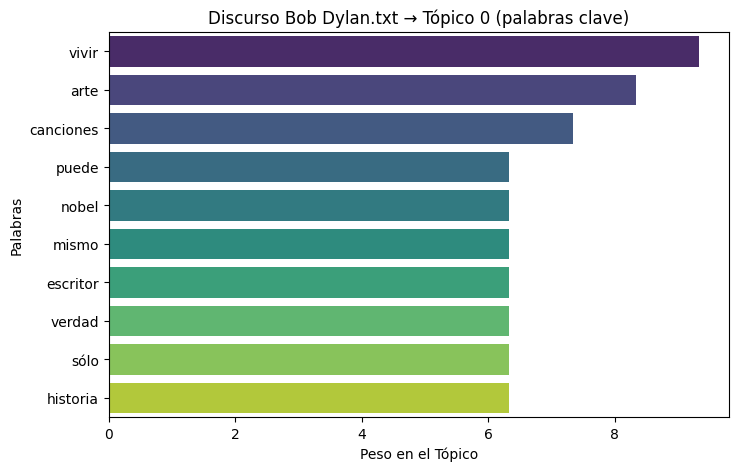

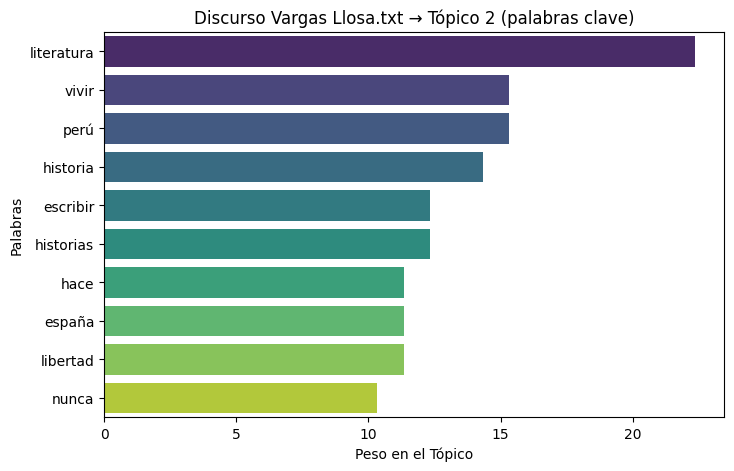

In [42]:
# Número de palabras a mostrar
top_n_words = 10  

# Extraer nombres del vocabulario
feature_names = vectorizer.get_feature_names_out()

# Asignar tópico dominante por documento
df_result = pd.DataFrame({
    "documento": df["nombre_archivo"].apply(lambda x: os.path.basename(x)),
    "topico_dominante": doc_topic_df.values.argmax(axis=1)
})

# Generar un gráfico por documento
for idx, row in df_result.iterrows():
    doc_name = row["documento"]
    topico = row["topico_dominante"]
    
    # Sacar las top palabras de ese tópico
    topic = lda.components_[topico]
    top_indices = topic.argsort()[::-1][:top_n_words]
    words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]
    
    # 📊 Gráfico
    plt.figure(figsize=(8,5))
    sns.barplot(x=weights, y=words, palette="viridis")
    plt.title(f"{doc_name} → Tópico {topico} (palabras clave)")
    plt.xlabel("Peso en el Tópico")
    plt.ylabel("Palabras")
    plt.show()
